<a href="https://colab.research.google.com/github/so-yeon-hwang/DataSciencePractice/blob/main/VanillaVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F
import torch.distributions as td                   # torch distribution 임포트
from torch.utils.data import TensorDataset

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm
from torchvision.utils import save_image

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy: 1.25.2
Torch:  2.2.1+cu121
Torchvision:  0.17.1+cu121


In [ ]:
# GPU 동작 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cpu
False


In [ ]:
# 하이퍼파라미터 설정
batch_size = 100
learning_rate = 0.001
num_epochs = 20

num_classes = 10

In [ ]:
# MNIST 데이터셋 import
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = '/MNIST_DATASET'

# PIL img (HxWxC) → torch tensor(CxHxW) & [0,255] → [0.0,1.0] 범위
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(download_root,
                     transform = mnist_transform,
                     train = True,
                     download = True)

test_dataset = MNIST(download_root,
                     transform = mnist_transform,
                     train = False,
                     download = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 85332171.46it/s]


Extracting /MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4719327.33it/s]


Extracting /MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32297478.63it/s]


Extracting /MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12080233.84it/s]

Extracting /MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw



In [ ]:
len(train_dataset)

60000

In [ ]:
# 데이터 형태 확인
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True) # batch_size = 100, len(train_loader) = 600 → total 60,000

test_loader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         shuffle = False)

def print_MNIST_data_loader_info(data_loader):
  print("dataset length : ", len(data_loader))
  print("batch size : ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  print("batch_imagest type : ", type(batch_images))
  print("batch_images shape : ", batch_images.shape)
  print("batch_images dtype : ", batch_images.dtype)

print("train dataset info")
print_MNIST_data_loader_info(train_loader)
print() # 줄바꿈

print("test dataset info")
print_MNIST_data_loader_info(test_loader)

train dataset info
dataset length :  600
batch size :  100
batch_imagest type :  <class 'torch.Tensor'>
batch_images shape :  torch.Size([100, 1, 28, 28])
batch_images dtype :  torch.float32

test dataset info
dataset length :  100
batch size :  100
batch_imagest type :  <class 'torch.Tensor'>
batch_images shape :  torch.Size([100, 1, 28, 28])
batch_images dtype :  torch.float32


In [ ]:
# VAE 모델설계
enc_dim = 2

class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()

    self.input = nn.Flatten() # 2Dimension 이미지 → 1Dimension 벡터
    self.fc1   = nn.Linear(784,256)
    self.fc2   = nn.Linear(256,128)
    self.fc3   = nn.Linear(128,64)
    self.fc4_1 = nn.Linear(64,enc_dim)
    self.fc4_2 = nn.Linear(64,enc_dim)

    self.fc5 = nn.Linear(enc_dim,64)
    self.fc6 = nn.Linear(64,128)
    self.fc7 = nn.Linear(128,256)
    self.fc8 = nn.Linear(256,784)

  def encoder(self,x):
    x = self.input(x)
    x = F.relu(self.fc1(x)) # fully connected
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    mean = self.fc4_1(x)
    log_var = self.fc4_2(x)

    return mean, log_var

  def decoder(self,z):
    z = F.relu(self.fc5(z))
    z = F.relu(self.fc6(z))
    z = F.relu(self.fc7(z))
    z = torch.sigmoid(self.fc8(z))

    return z # latent space

  def forward(self,x):
    mu, log_var = self.encoder(x.view(-1,784))

    std = log_var.exp().pow(0.5)
    q_z = td.normal.Normal(mu,std)
    z = q_z.rsample()

    return self.decoder(z), q_z

vae = VAE().to(device)
print(vae)

VAE(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=2, bias=True)
  (fc4_2): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)


In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(vae,[batch_size,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [100, 784]                --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 256]                200,960
├─Linear: 1-3                            [100, 128]                32,896
├─Linear: 1-4                            [100, 64]                 8,256
├─Linear: 1-5                            [100, 2]                  130
├─Linear: 1-6                            [100, 2]                  130
├─Linear: 1-7                            [100, 64]                 192
├─Linear: 1-8                            [100, 128]                8,320
├─Linear: 1-9                            [100, 256]                33,024
├─Linear: 1-10                           [100, 784]                201,488
Total params: 485,396
Trainable params: 485,396
Non-trainable params: 0
Total mult-adds (M): 48.54
Input size (MB): 0.31
Forward

In [ ]:
batch_images_0 , batch_labels_0 = train_dataset[0]
batch_images_0.shape # unsqueeze(차원 확장) 전 [1,28,28] (=[높이,채널,너비])

torch.Size([1, 28, 28])

In [ ]:
image, label = train_dataset[0]
test1 = torch.unsqueeze(image,0).to(device)  # torch.Size([1, 1, 28, 28])
result1 = vae(test1)
len(result1) # 2
y1, _ = result1
print(y1.shape)
y1 = y1.view(1,28,28)
y1.shape

torch.Size([1, 784])


torch.Size([1, 28, 28])

In [ ]:
# 데이터 하나 뽑아보기
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print("GT label : ", label)

  X = torch.unsqueeze(image,0).to(device) # 0번째 인덱스에 dimension 추가
  Y_pred, _ = vae(X) # raw data를 VAE 모델에 넣고 돌린 결과 (=x')
  Y_pred = Y_pred.view(1,28,28)

  input_img = to_pil_image(X.squeeze()) # 2차원으로 축소 for 시각화
  output_img = to_pil_image(Y_pred.squeeze()) # 2차원으로 축소 for 시각화

  plt.subplot(121)
  plt.imshow(input_img, cmap = 'gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap = 'gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx = widgets.IntSlider(min = 0, max = len(train_dataset)-1),
                 continuous_update = False)


interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

<function __main__.train_dataset_imshow(idx)>

In [ ]:
# 테스트를 위한 임시 data loader 생성
tmp_loader = DataLoader(dataset = train_dataset,
                        batch_size = 60000, # 배치 사이즈 60000 == 전체 트레인셋 크기
                        shuffle = True)

In [ ]:
batch_images, batch_labels = next(iter(tmp_loader))
batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

# 인코더에 돌리기 - 평균과 분산을 인코더를 통해 추출
enc_mean, enc_var = vae.encoder(batch_images)

if use_cuda:
  # 01) 표준편차 계산 : enc_var(분산, 로그 스케일)을 exp() 함수로 다시 변환하고 제곱근 계산하여 표준편차 생성
  std = enc_var.exp().pow(0.5)

  # 02) 인코더(q)를 통해 만들어진 평균과 표준편차를 바탕으로 정규분포 생성
  #     이 분포는 VAE에서 잠재변수 z를 샘플링하기 위해 만들어진 것
  q_z = td.normal.Normal(enc_mean,std)

  # 03) rsample() 함수 : PyTorch의 Distribution 클래스에서 사용되는 함수, 해당 분포로부터 샘플을 추출
  #     reparameterization trick 사용
  z = q_z.rsample()

  # 04) z~p(z)를 디코더에 돌리기
  y = vae.decoder(z).reshape(len(batch_images), 1,28,28).to(device)

else :
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean,std)
  z = q_z.rsample()
  y = vae.decoder(z).reshape(len(batch_images),1,28,28)

print(y.shape)

torch.Size([60000, 1, 28, 28])


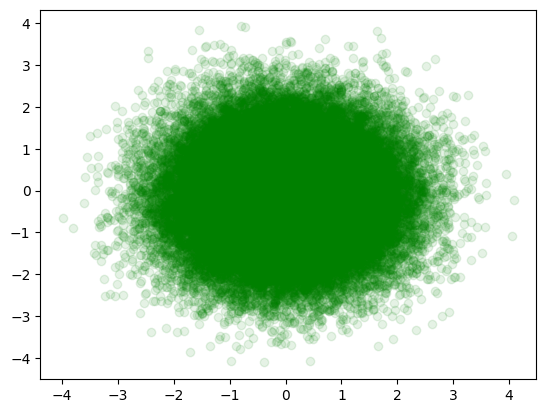

In [ ]:
pt = z.cpu().detach().numpy()
plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

In [ ]:
# Optimizer, Loss Function

def criterion(x_hat, x, q_z): # criterion 손실함수
  BCE = F.binary_cross_entropy(x_hat,x.view(-1,784), reduction = 'sum')
  p_z = td.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
  KLD = td.kl_divergence(q_z, p_z).sum()
  return BCE + KLD

optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)

In [ ]:
# 모델 학습

for epoch in range(num_epochs):
  now = time.time()
  train_loss = 0
  avg_loss = 0

  for i, (batch_images, batch_label) in enumerate(train_loader):

    X = batch_images
    if use_cuda:
      X = X.to(device) # input data

    # forward
    Y_prediction , q_z = vae(X) # output data 변수할당
    loss = criterion(Y_prediction, X, q_z) # loss function 돌리기

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

# vae() 모델 학습 완료

[Epoch:    1] 	 loss = 164.4714 	 time = 21.7718
[Epoch:    2] 	 loss = 156.8960 	 time = 19.9883
[Epoch:    3] 	 loss = 152.9009 	 time = 20.9040
[Epoch:    4] 	 loss = 150.0677 	 time = 21.3903
[Epoch:    5] 	 loss = 147.9311 	 time = 20.9020
[Epoch:    6] 	 loss = 146.5029 	 time = 23.1747
[Epoch:    7] 	 loss = 145.4426 	 time = 21.3230
[Epoch:    8] 	 loss = 144.6400 	 time = 23.2317
[Epoch:    9] 	 loss = 143.7043 	 time = 20.9503
[Epoch:   10] 	 loss = 143.2963 	 time = 21.6621
[Epoch:   11] 	 loss = 143.1642 	 time = 22.0373
[Epoch:   12] 	 loss = 142.4073 	 time = 20.7959
[Epoch:   13] 	 loss = 141.9776 	 time = 21.5299
[Epoch:   14] 	 loss = 141.7606 	 time = 21.4594
[Epoch:   15] 	 loss = 141.0744 	 time = 20.8674
[Epoch:   16] 	 loss = 140.9627 	 time = 21.3557
[Epoch:   17] 	 loss = 140.8458 	 time = 21.6570
[Epoch:   18] 	 loss = 140.5364 	 time = 21.4169
[Epoch:   19] 	 loss = 139.9993 	 time = 21.0367
[Epoch:   20] 	 loss = 139.9316 	 time = 21.5117
Learning Finished!


In [ ]:
# input / output 데이터 시각화
widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [ ]:
# if use_cuda:
#   # 01) 표준편차 계산 : enc_var(분산, 로그 스케일)을 exp() 함수로 다시 변환하고 제곱근 계산하여 표준편차 생성
#   std = enc_var.exp().pow(0.5)

#   # 02) 인코더(q)를 통해 만들어진 평균과 표준편차를 바탕으로 정규분포 생성
#   #     이 분포는 VAE에서 잠재변수 z를 샘플링하기 위해 만들어진 것
#   q_z = td.normal.Normal(enc_mean,std)

#   # 03) rsample() 함수 : PyTorch의 Distribution 클래스에서 사용되는 함수, 해당 분포로부터 샘플을 추출
#   #     reparameterization trick 사용
#   z = q_z.rsample()

#   # 04) z~p(z)를 디코더에 돌리기
#   y = vae.decoder(z).reshape(len(batch_images), 1,28,28).to(device)

In [ ]:
batch_images, batch_labels = next(iter(tmp_loader))
batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
enc_mean, enc_var = vae.encoder(batch_images)

if use_cuda:
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std) # 잠재공간 정규분포 생성
  z = q_z.rsample() # 잠재공간 정규분포에서 랜덤 샘플링
  y = vae.decoder(z).reshape(len(batch_images), 1, 28, 28).to(device) # 뽑은 샘플 디코더에 돌리기

else:
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)
  z = q_z.rsample()
  y = vae.decoder(z).reshape(len(batch_images), 1, 28, 28)

print(y.shape) # x' 생성

torch.Size([60000, 1, 28, 28])


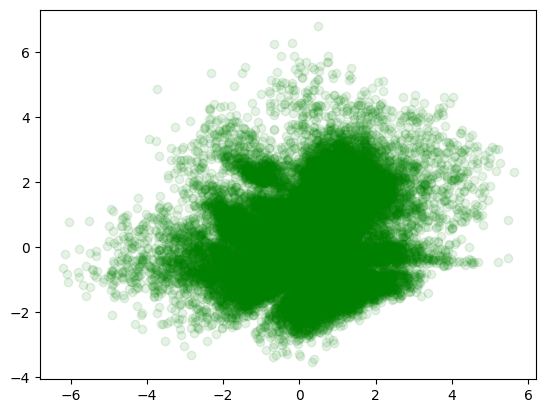

In [ ]:
# 완성된 y 값의 전체 분포를 시각화

pt = z.cpu().detach().numpy()
plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

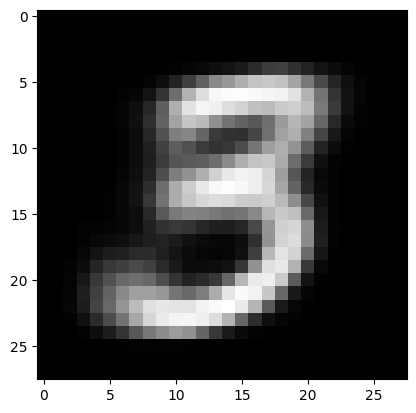

In [ ]:
# 잠재공간 z에서 점 하나를 뽑아서 시각화
z = torch.Tensor([[1.5, -0.3]]).to(device) # z에서 [1.5,-0.3]을 뽑았다는 뜻
y = vae.decoder(z)

img = y.cpu().detach().numpy()
plt.imshow(img.reshape(28,28),cmap='gray')